In [1]:
import pandas as pd
import numpy as np
import re
import os
!pip install sentencepiece
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

     |████████████████████████████████| 1.0MB 32.8MB/s 


In [2]:

import fastai, torch
fastai.__version__ , torch.__version__

('1.0.60', '1.4.0')

In [3]:
data_df = pd.read_parquet('drive/My Drive/nlp-telugu/telugu_news_dataset.parquet')
data_df.shape, data_df.columns

((20527, 3), Index(['title', 'text', 'category'], dtype='object'))

In [4]:
data_df['t'] = (data_df['title'] + ' ' + data_df['text']).tolist()
data_df['t'].str.len().mean(), data_df['t'].str.len().min(), data_df['t'].str.len().max()# in characters

(1172.7989477273834, 1, 14027)

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df.shape, test_df.shape

((16421, 4), (4106, 4))

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [7]:
from inltk.tokenizer import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [8]:
data_lm = TextLMDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_cls_lm.data')

In [9]:
data_lm.show_batch()

idx,text
0,"లి టిక్స్ ▁ , ▁ఆటో మే షన్ ▁ , ▁మెషీన్ ▁ లెర్ నింగ్ ▁ , ▁కృత్రిమ ▁మే ధ , ▁రి స్క్ ▁మేనేజ్ ▁మెంట్ ▁అంశాల్లో ▁ఈ ▁2 ▁కేంద్రాలు ▁సహాయం ▁చేయ ను న్నాయి . ▁హైదరాబాద్ ▁లో ▁ప్రాథమికంగా ▁100 ▁మందికి ▁పైగా ▁ఉద్యోగుల ను ▁తీసుకున్న ట్లు , ▁రా నున్న ▁రోజుల్లో ▁ఈ ▁సంఖ్య ▁మరింత ▁పెరుగ ుతుందని ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁చీఫ్ ▁రి స్క్ ▁ఆఫీసర్ ▁సీ న్ ▁రింగ్ ▁స్టె డ్ ▁తెలిపారు . ▁ఇప్పటివరకు ▁హైదరాబాద్ ▁లోని"
1,"▁మీదుగా ▁టీ జర్ ▁విడుదలైంది . ▁అనంతరం ▁ఆమె ▁మాట్లాడుతూ ▁‘‘ సినిమా ▁ర షె స్ ▁ని ▁చూసిన ప్పుడే ▁మేఘ ా మ్ ష్ ▁లో ▁శ్రీహరి ని ▁చూశా . ▁చురుకైన ▁నటన , ▁నృత్య ాలతో ▁శ్రీహరి ని ▁మించి ▁పేరు ▁సంపాదిస్త ాడ ’’ న్నారు . ▁‘‘ మే ఘా మ్ ష్ ▁తో ▁రెండో ▁చిత్ర ాన్నీ ▁తీ స్తాం ’’ ▁అన్నారు ▁నిర్మాత . ▁శాంతి ▁శ్రీహరి ▁మాట్లాడుతూ ▁‘‘ మే ఘా మ్ ష్ ▁చేసిన ▁ఒకే ▁ఒక ▁షాట్ ▁ని ▁చూశా . ▁అందులో"
2,"ఎస్ ▁ఎమ్ ▁ఈ , ▁గృహ , ▁రిటైల్ ▁రంగాల కు ▁రుణ ాలు ▁ఇస్తా రని ▁తెలిపారు . ▁ఎం ఎస్ ▁ఎం ఈ ▁రుణ ాలను ▁మార్చి ▁వరకు ▁ఎన్ ▁పీ ఏ గా ▁ప్రకటించ ొద్ద ు : ▁ఒత్తిడి లో ▁ఉన్న ▁ఎం ఎస్ ▁ఎం ఈ ▁రుణ ాలను ▁2020 ▁మార్చి ▁వరకు ▁నిర ర్థ క ▁ఆస్తులు గా ▁ప్రకటించ వద్దని ▁బ్యాంకు ల్ని ▁ప్రభుత్వం ▁కోరింది . ▁ప్రభుత్వ ▁రంగ ▁( పీ ఎస్ ▁యూ ) ▁బ్యాంకు ల ▁అధి పతుల తో ▁సమావేశ మైన ▁అనంతరం"
3,"▁వైపున ▁చెట్టు ▁కింద ▁హైదరాబాద్ ▁చైతన్య పురి ▁డివిజన్ ▁మున్సిపల్ ▁కాలనీ కి ▁చెందిన ▁పి . మల్ల ేష్ ▁ , ▁ఆయన ▁కుమార్తె ▁ప్రణ తి , ▁తల్లి ▁బు చ్చె మ్మ ▁నిద్ర కు ▁ఉప క్రమ ించారు . ▁గమనించ ని ▁కాని స్టే బుల్ ▁( వాహన ▁డ్రైవర్ ▁) ▁అంబ టి ▁శేఖర్ ▁పోలీసు ▁వాహన ాన్ని ▁ముందుకు ▁నడిపాడు . ▁వాహనం ▁ప్రణ తి ▁తల ▁పై నుంచి ▁వెళ్ల డంతో ▁తీవ్రంగా ▁గాయపడ ింది . ▁మల్ల ేష్ ▁కు ▁స్వల్ప ▁గాయాల య్యాయి . ▁వారిని"
4,▁ఇతరత్రా ▁సమర్పణ ల ▁ప్రాతిపదికన ▁మాత్రమే ▁ఆయా ▁పక్షాల ▁రి జ ాయి ండర్ లు ▁ఉండాలని ▁స్పష్టం ▁చేసింది . ▁x x bo s ▁మే లో ▁ఉ బర్ ▁మెగా ▁పబ్లిక్ ▁ఇ ష్ యూ ▁10 ▁బిలియన్ ▁డాలర్ల ▁సమీకరణ ▁లక్ష్యం ▁శాన్ ▁ఫ్రాన్సిస్కో : ▁100 ▁బిలియన్ ▁డాలర్ల ▁కంపెనీ గా ▁అవతరించ ే ▁లక్ష్యంతో ▁మెగా ▁పబ్లిక్ ▁ఇ ష్ యూ కు ▁ఉ బర్ ▁సిద్ధ మైంది . ▁ఈ ▁ఏడాది లోనే ▁ఆ ▁మెగా ▁ఐ పీ ఓ ▁( తొ లి ▁పబ్లిక్ ▁ఆ ఫర్


In [51]:
learn = load_learner('drive/My Drive/nlp-telugu/', 'export.pkl')

In [ ]:
!cp -r 'drive/My Drive/nlp-telugu/models/trained_model.pth' 'models/'

In [52]:
learn.save("./trained_model", return_path=True)

PosixPath('drive/My Drive/nlp-telugu/models/trained_model.pth')

In [12]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)

In [13]:
learn.load('trained_model', with_opt=True)

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:279: UserWarning: Saved filed doesn't contain an optimizer state.
  if with_opt: warn("Saved filed doesn't contain an optimizer state.")


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (16421 items)
x: LMTextList
▁x x bo s ▁హైదరాబాద్ ▁లో ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁టెక్నాలజీ ▁కేంద్రం ▁ఈనాడు , ▁హైదరాబాద్ ▁: ▁స్థిర ా స్తి , ▁క్యా జు వా లిటీ ▁బీమా ▁సేవలు ▁అందించే ▁అమెరికాకు ▁చెందిన ▁అంతర్జాతీయ ▁సంస్థ ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁హైదరాబాద్ ▁లో ▁తన ▁సాంకేతిక ▁సేవా ▁కేంద్రాన్ని ▁ఏర్పాటు ▁చేసింది . ▁మరో ▁కేంద్రాన్ని ▁బెంగళూరు లోనూ ▁ప్రారంభించ ను ంది . ▁ ప్రపంచవ్యాప్తంగా ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁కు ▁అవసరమైన ▁సాంకేతిక , ▁డిజిటల్ ▁ , ▁డేటా ▁అన లి టిక్స్ ▁ , ▁ఆటో మే షన్ ▁ , ▁మెషీన్ ▁ లెర్ నింగ్ ▁ , ▁కృత్రిమ ▁మే ధ , ▁రి స్క్ ▁మేనేజ్ ▁మెంట్ ▁అంశాల్లో ▁ఈ ▁2 ▁కేంద్రాలు ▁సహాయం ▁చేయ ను న్నాయి . ▁హైదరాబాద్ ▁లో ▁ప్రాథమికంగా ▁100 ▁మందికి ▁పైగా ▁ఉద్యోగుల ను ▁తీసుకున్న ట్లు , ▁రా నున్న ▁రోజుల్లో ▁ఈ ▁సంఖ్య ▁మరింత ▁పెరుగ ుతుందని ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁చీఫ్ ▁రి స్క్ ▁ఆఫీసర్ ▁సీ న్ ▁రింగ్ ▁స్టె డ్ ▁తెలిపారు . ▁ఇప్పటివరకు ▁హైదరాబాద్ ▁లోని ▁టెట్రా సా ఫ్ట్ ▁తో ▁కలిసి ▁పనిచేసిన ▁ఈ ▁సంస్థ ▁అందులోని ▁నిపుణుల ను ▁తన ▁పూర్తిస్థాయి ▁ఉద్యోగులు గా ▁తీసుకుంది . ▁గ్ల

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


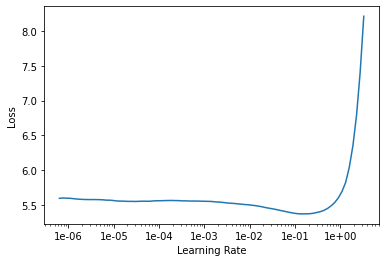

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.save('fit_head', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,4.266157,4.105313,0.323075,01:28
1,3.964733,3.947344,0.342401,01:28


In [16]:
learn.load('fit_head', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (16421 items)
x: LMTextList
▁x x bo s ▁హైదరాబాద్ ▁లో ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁టెక్నాలజీ ▁కేంద్రం ▁ఈనాడు , ▁హైదరాబాద్ ▁: ▁స్థిర ా స్తి , ▁క్యా జు వా లిటీ ▁బీమా ▁సేవలు ▁అందించే ▁అమెరికాకు ▁చెందిన ▁అంతర్జాతీయ ▁సంస్థ ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁హైదరాబాద్ ▁లో ▁తన ▁సాంకేతిక ▁సేవా ▁కేంద్రాన్ని ▁ఏర్పాటు ▁చేసింది . ▁మరో ▁కేంద్రాన్ని ▁బెంగళూరు లోనూ ▁ప్రారంభించ ను ంది . ▁ ప్రపంచవ్యాప్తంగా ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁కు ▁అవసరమైన ▁సాంకేతిక , ▁డిజిటల్ ▁ , ▁డేటా ▁అన లి టిక్స్ ▁ , ▁ఆటో మే షన్ ▁ , ▁మెషీన్ ▁ లెర్ నింగ్ ▁ , ▁కృత్రిమ ▁మే ధ , ▁రి స్క్ ▁మేనేజ్ ▁మెంట్ ▁అంశాల్లో ▁ఈ ▁2 ▁కేంద్రాలు ▁సహాయం ▁చేయ ను న్నాయి . ▁హైదరాబాద్ ▁లో ▁ప్రాథమికంగా ▁100 ▁మందికి ▁పైగా ▁ఉద్యోగుల ను ▁తీసుకున్న ట్లు , ▁రా నున్న ▁రోజుల్లో ▁ఈ ▁సంఖ్య ▁మరింత ▁పెరుగ ుతుందని ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁చీఫ్ ▁రి స్క్ ▁ఆఫీసర్ ▁సీ న్ ▁రింగ్ ▁స్టె డ్ ▁తెలిపారు . ▁ఇప్పటివరకు ▁హైదరాబాద్ ▁లోని ▁టెట్రా సా ఫ్ట్ ▁తో ▁కలిసి ▁పనిచేసిన ▁ఈ ▁సంస్థ ▁అందులోని ▁నిపుణుల ను ▁తన ▁పూర్తిస్థాయి ▁ఉద్యోగులు గా ▁తీసుకుంది . ▁గ్ల

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('fine_tuned', with_opt=True)
learn.save_encoder('fine_tuned_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,3.784742,3.812493,0.358350,01:45
1,3.684562,3.708102,0.371162,01:45
2,3.406459,3.546307,0.393026,01:45
3,3.051107,3.448967,0.408565,01:45
4,2.701525,3.474136,0.410096,01:45


In [ ]:
del data_lm, learn

In [20]:
import gc
gc.collect()

126

In [ ]:
torch.cuda.empty_cache()

In [21]:
data_clas = TextClasDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], label_cols = ['category'], bs=48,
                                  tokenizer=tokenizer, vocab=telugu_vocab)

In [22]:
data_clas.show_batch()


text,target
▁x x bo s ▁మనం ▁అ జేయ ుల ం ▁ఎదురు లేని ▁టీ మ్ ▁ఇండియా ▁పాక్ ▁పై ▁కొనసాగిన ▁జై త్ర యాత్ర ▁రో హి త్ ▁సూపర్ ▁సెంచరీ ▁మాయ ▁చేసిన ▁కు ల్ ▁ దీప్ ▁4 ▁మార్చి ▁1992 . . ▁9 ▁మార్చి ▁1996 . . ▁8 ▁జూన్ ▁1999 . . ▁1 ▁మార్చి ▁2003 . . ▁30 ▁మార్చి ▁2011 . . ▁15 ▁ఫిబ్రవరి ▁2015 . . ▁భారత ▁క్రికెట్ ▁అభిమానుల ▁హృదయ ాలు ▁ఉప్ప ొ ంగ ేలా,eenadu_sports
▁x x bo s ▁350 ▁లక్షల ▁కోట్ల ▁స్థాయికి . . ▁20 24 - 25 కు ▁భారత ▁ఆర్థిక ▁వ్యవస్థ ▁8 ▁శాతం ▁వృద్ధి తోనే ▁సాధ్యం ▁భయ పెడుతున్న ▁ద్రవ్య ▁లోటు ▁ప్రైవేటు ▁పెట్టుబడుల తో ▁అధిక ▁వృద్ధి ▁7 ▁శాతం ▁2019 -20 ▁జీ డీ పీ ▁వృద్ధి ▁అంచనా ▁ఆర్థిక ▁సర్వే ▁2018 -19 ▁అయి దే ళ్లలో ▁5 ▁లక్షల ▁కోట్ల ▁డాలర్ల ▁( సుమారు ▁రూ . 3 50 ▁లక్షల ▁కోట్ల ) ▁ఆర్థిక ▁వ్యవస్థ ే ▁లక్ష్యం . . ▁ప్రధాని ▁నరేంద్ర ▁మో,eenadu_business
▁x x bo s ▁గులాబీ ▁ము ంగి ట ▁ఘనంగా . . ▁తొలి ▁టెస్టు లో ▁భారత్ ▁భారీ ▁విజయం ▁కనీస ▁పోటీ ▁ఇవ్వ ని ▁బంగ్లాదేశ్ ▁ఇన్నింగ్స్ ▁130 ▁పరుగుల ▁తేడాతో ▁చిత్త ు ▁పే సర్ ల ▁ధాటికి ▁రెండో ▁ఇన్నింగ్స్ ▁లో ▁21 3 కే ▁ఆ ల ౌట్ ▁సొంత గడ్డ పై ▁కో హ్ లీ సేన ▁ధాటికి ▁మహా ▁మహా ▁జట్ల ే ▁బెం బే లె త్తి పోయాయి . ▁మరి ▁బంగ్లాదేశ్ ▁మాత్రం ▁నిలుస్త ుందని ▁ఎలా ▁అను కుంట ాం ? ▁అస్స,eenadu_sports
▁x x bo s ▁కుర్ర ాడు ▁కొట్ట ాడు ▁డబుల్ ▁సెంచరీ తో ▁చెలరేగ ిన ▁మ యాం క్ ▁భారత్ ▁502 ▁/ ▁7 ▁ డిక్ లే ర్డ్ ▁దక్షిణాఫ్రికా ▁39 ▁/ ▁3 ▁విశాఖ లో ▁తొలి ▁టెస్టు ▁సొంత గడ్డ పై ▁తొలి ▁టె స్టే ▁అయినా ▁మ యాం క్ ▁అగర్వాల్ ▁అ దర గొట్ట ాడు . ▁చిరస్మరణీయ ▁ఇన్నింగ్స్ ▁తో ▁ఆనంద ాన్ని ▁‘ డ బుల్ ▁’ ▁చేసుకున్నాడు . ▁చూడ ము చ్చ ట ైన ▁బ్యాటింగ్ ▁తో ▁ఆకట్టుకున్న ▁మ యాం క్,eenadu_sports
▁x x bo s ▁పది లో ▁మెచ్చి న ▁పద ు గురు ▁2010 -20 19 ▁‘‘ ప్రతి ▁ము ప్ ఫై ▁సంవత్సరాలకు ▁బతుకు ▁తాలూకు ▁ఆలోచన ▁మారుతుంది . ▁సినిమా ▁వాళ్లు ▁దాన్ని ▁ట్రె ండ్ ▁అంటారు . ▁వ్యాపారవేత్త లు ▁ఫ్యాషన్ ▁అంటారు . ▁రాజకీయ ▁నాయకులు ▁తరం ▁అంటారు . ▁మామూలు ▁జనం ▁జన రేషన్ ▁అంటారు . ▁కానీ ▁ప్రతి ▁జన రేషన్ ▁లోనూ ▁ఆ ▁కొత్త ▁థా ట్ ▁ని ▁ముందుకు ▁తీసుకెళ్ల ేవాడు ▁ఒక్కడే ▁వస్తాడు . ▁వా ణ్ ని ▁టార్ చ్ ▁బేర,eenadu_cinema


In [ ]:

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [24]:
learn.load_encoder('fine_tuned_encoder')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (16421 items)
x: TextList
▁x x bo s ▁హైదరాబాద్ ▁లో ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁టెక్నాలజీ ▁కేంద్రం ▁ఈనాడు , ▁హైదరాబాద్ ▁: ▁స్థిర ా స్తి , ▁క్యా జు వా లిటీ ▁బీమా ▁సేవలు ▁అందించే ▁అమెరికాకు ▁చెందిన ▁అంతర్జాతీయ ▁సంస్థ ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁హైదరాబాద్ ▁లో ▁తన ▁సాంకేతిక ▁సేవా ▁కేంద్రాన్ని ▁ఏర్పాటు ▁చేసింది . ▁మరో ▁కేంద్రాన్ని ▁బెంగళూరు లోనూ ▁ప్రారంభించ ను ంది . ▁ ప్రపంచవ్యాప్తంగా ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁కు ▁అవసరమైన ▁సాంకేతిక , ▁డిజిటల్ ▁ , ▁డేటా ▁అన లి టిక్స్ ▁ , ▁ఆటో మే షన్ ▁ , ▁మెషీన్ ▁ లెర్ నింగ్ ▁ , ▁కృత్రిమ ▁మే ధ , ▁రి స్క్ ▁మేనేజ్ ▁మెంట్ ▁అంశాల్లో ▁ఈ ▁2 ▁కేంద్రాలు ▁సహాయం ▁చేయ ను న్నాయి . ▁హైదరాబాద్ ▁లో ▁ప్రాథమికంగా ▁100 ▁మందికి ▁పైగా ▁ఉద్యోగుల ను ▁తీసుకున్న ట్లు , ▁రా నున్న ▁రోజుల్లో ▁ఈ ▁సంఖ్య ▁మరింత ▁పెరుగ ుతుందని ▁చ బ్ ▁ఇన్ సూ రెన్స్ ▁చీఫ్ ▁రి స్క్ ▁ఆఫీసర్ ▁సీ న్ ▁రింగ్ ▁స్టె డ్ ▁తెలిపారు . ▁ఇప్పటివరకు ▁హైదరాబాద్ ▁లోని ▁టెట్రా సా ఫ్ట్ ▁తో ▁కలిసి ▁పనిచేసిన ▁ఈ ▁సంస్థ ▁అందులోని ▁నిపుణుల ను ▁తన ▁పూర్తిస్థాయి ▁ఉద్యోగులు గా ▁తీసుకుంది . ▁గ్లోబల్ 

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


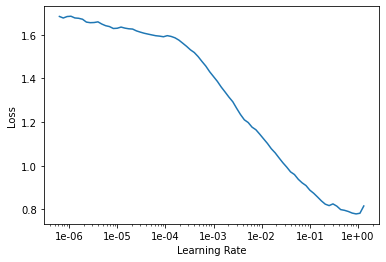

In [26]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
kappa = KappaScore()
learn.metrics = [kappa, accuracy]

In [ ]:
torch.cuda.empty_cache()


In [28]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))
learn.save('first_cls', with_opt=True)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.251664,0.193722,0.928122,0.943497,03:56
1,0.208174,0.174481,0.932760,0.947151,03:56
2,0.168100,0.142732,0.938615,0.951778,04:10
3,0.158437,0.133545,0.938689,0.951778,04:54
